# Last Notebook
In this notebook, you will have to predict whether a candidate was hired or not (i.e., predict the column `embauche`).
The dataset is composed of 11 columns (features):
- date – application date 
– age: age of the candidate
- diplome – Highest diploma obtained (bac, licence, master, doctorat)
- specialite – speciality of the diploma (geology, detective, archeology, . . . )
- salaire – salaire demanded by the candidate
- dispo – oui : immediate avaialability, non : not available immediately
- sexe – female (F) or male (M)
- exp – nbr of years of experience
- cheveux – color of hair (châtain, brun, blond, roux)
- note – grade (over 100) obtained on the exercise
- embauche – 1: the candidate got hired, 0 the candidate did not get hired.

To complete this test, you will have to:
1. Split the data into train (70%), validation(10%), and test(20%) sets. 
2. Explore the data: look at your data, their types, check for missing values, incorrect values, duplicates, do some visualizations, set a list of changes you need to apply on these columns (one-hot encode some columns, bin others, eliminate others, etc.), check for balance or imbalance.
3. Apply the feature engineering you have identified in the previous step (the one-hot encoding, etc.)
4. Identify the metric to be optimized here (is it accuracy, precision, recall, f1-score, etc.)
5. Try several Machine Learning Models and do hyperparameter tuning using the validation set to find the best performing model.
6. Test your best model (or ensemble of models) on the test set, explain the results you got, and recommend on next steps (modifications that might bring better results).

Bonus: Deal with imbalance if any.


In [58]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import pearsonr
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
try:
    from xgboost import XGBClassifier
except:
    !pip install xgboost
    from xgboost import XGBClassifier
from sklearn.svm import SVC
try:
    from imblearn.over_sampling import SMOTE
except:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv("./data.csv")

# 1. **Data Cleaning**

In [3]:
df.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   index       20000 non-null  int64  
 2   date        19909 non-null  object 
 3   cheveux     19897 non-null  object 
 4   age         19909 non-null  float64
 5   exp         19904 non-null  float64
 6   salaire     19905 non-null  float64
 7   sexe        19900 non-null  object 
 8   diplome     19890 non-null  object 
 9   specialite  19907 non-null  object 
 10  note        19886 non-null  float64
 11  dispo       19894 non-null  object 
 12  embauche    20000 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 2.0+ MB


In [8]:
print(df.isnull().sum())

cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64


As we can see from the table above, many features have missing values. Therefore, I proceeded to drop all the rows with missing values. A viable alternative option would have been to impute the missing values with a statistic of choice (for example, the median, or the mean in absence of strong outliers).

In [9]:
df.dropna(inplace=True)

In [5]:
df.nunique()

Unnamed: 0    20000
index         20000
date           1826
cheveux           4
age              76
exp              25
salaire       12326
sexe              2
diplome           4
specialite        4
note           6679
dispo             2
embauche          2
dtype: int64

Deleting redundant columns:

In [6]:
df.drop(columns=["Unnamed: 0", "date"], inplace=True)
df.set_index("index", inplace=True)

df.tail()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,
19995,roux,47.0,9.0,35723.0,M,licence,geologie,66.47,non,0
19996,chatain,38.0,10.0,33570.0,F,master,geologie,62.29,non,1
19997,chatain,23.0,6.0,33751.0,F,doctorat,detective,103.48,oui,0
19998,chatain,33.0,11.0,34167.0,F,licence,detective,73.35,non,0
19999,brun,35.0,14.0,44499.0,M,bac,geologie,45.62,non,0


In [7]:
print(df.dtypes)

cheveux        object
age           float64
exp           float64
salaire       float64
sexe           object
diplome        object
specialite     object
note          float64
dispo          object
embauche        int64
dtype: object


In [10]:
print(df.duplicated().sum())

0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19109 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cheveux     19109 non-null  object 
 1   age         19109 non-null  float64
 2   exp         19109 non-null  float64
 3   salaire     19109 non-null  float64
 4   sexe        19109 non-null  object 
 5   diplome     19109 non-null  object 
 6   specialite  19109 non-null  object 
 7   note        19109 non-null  float64
 8   dispo       19109 non-null  object 
 9   embauche    19109 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 1.6+ MB


In [12]:
df.describe()

,age,exp,salaire,note,embauche
count,19109.000000,19109.000000,19109.000000,19109.000000,19109.000000
mean,34.998953,9.496939,34971.291172,75.174708,0.114867
std,9.608132,3.010893,5004.727931,17.108645,0.318870
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.090000,0.000000
75%,41.000000,12.000000,38354.000000,86.660000,0.000000
max,72.000000,23.000000,53977.000000,143.220000,1.000000


In [13]:
df

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
5,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1
...,...,...,...,...,...,...,...,...,...,...
19995,roux,47.0,9.0,35723.0,M,licence,geologie,66.47,non,0
19996,chatain,38.0,10.0,33570.0,F,master,geologie,62.29,non,1
19997,chatain,23.0,6.0,33751.0,F,doctorat,detective,103.48,oui,0


# 2. **Exploratory Data Analysis**

## 2.1 *Univariate Data Analysis*

In [14]:
# summary table for each column 
for col in df.select_dtypes(include=["int", "float64"]).columns:
    print(f"Summary for {col}:")
    print(df[col].value_counts())
    print("_"*14)

Summary for age:
 35.0    1534
 34.0     773
 33.0     761
 36.0     750
 32.0     725
         ... 
-3.0        1
 71.0       1
 1.0        1
 68.0       1
-2.0        1
Name: age, Length: 75, dtype: int64
______________
Summary for exp:
 9.0     2525
 10.0    2378
 11.0    2276
 8.0     2264
 7.0     1804
 12.0    1773
 13.0    1302
 6.0     1297
 14.0     851
 5.0      833
 15.0     474
 4.0      460
 3.0      270
 16.0     237
 17.0     124
 2.0      106
 1.0       44
 18.0      44
 0.0       23
 19.0      16
 20.0       4
 21.0       1
-1.0        1
 23.0       1
-2.0        1
Name: exp, dtype: int64
______________
Summary for salaire:
37347.0    9
38085.0    7
36198.0    7
34687.0    7
31927.0    7
          ..
33626.0    1
37218.0    1
28558.0    1
36941.0    1
44499.0    1
Name: salaire, Length: 12045, dtype: int64
______________
Summary for note:
73.42     13
77.26     12
80.56     11
82.05     11
79.30     11
          ..
34.28      1
35.38      1
119.06     1
90.58      1
45

In [15]:
# summary table for each column 
for col in df.select_dtypes(include=["object"]).columns:
    print(f"Summary for {col}:")
    print(df[col].value_counts())
    print("_"*20)

Summary for cheveux:
chatain    5784
brun       5750
blond      5684
roux       1891
Name: cheveux, dtype: int64
____________________
Summary for sexe:
M    11415
F     7694
Name: sexe, dtype: int64
____________________
Summary for diplome:
master      7222
licence     7084
doctorat    2447
bac         2356
Name: diplome, dtype: int64
____________________
Summary for specialite:
geologie       9623
forage         4175
detective      3982
archeologie    1329
Name: specialite, dtype: int64
____________________
Summary for dispo:
non    11376
oui     7733
Name: dispo, dtype: int64
____________________


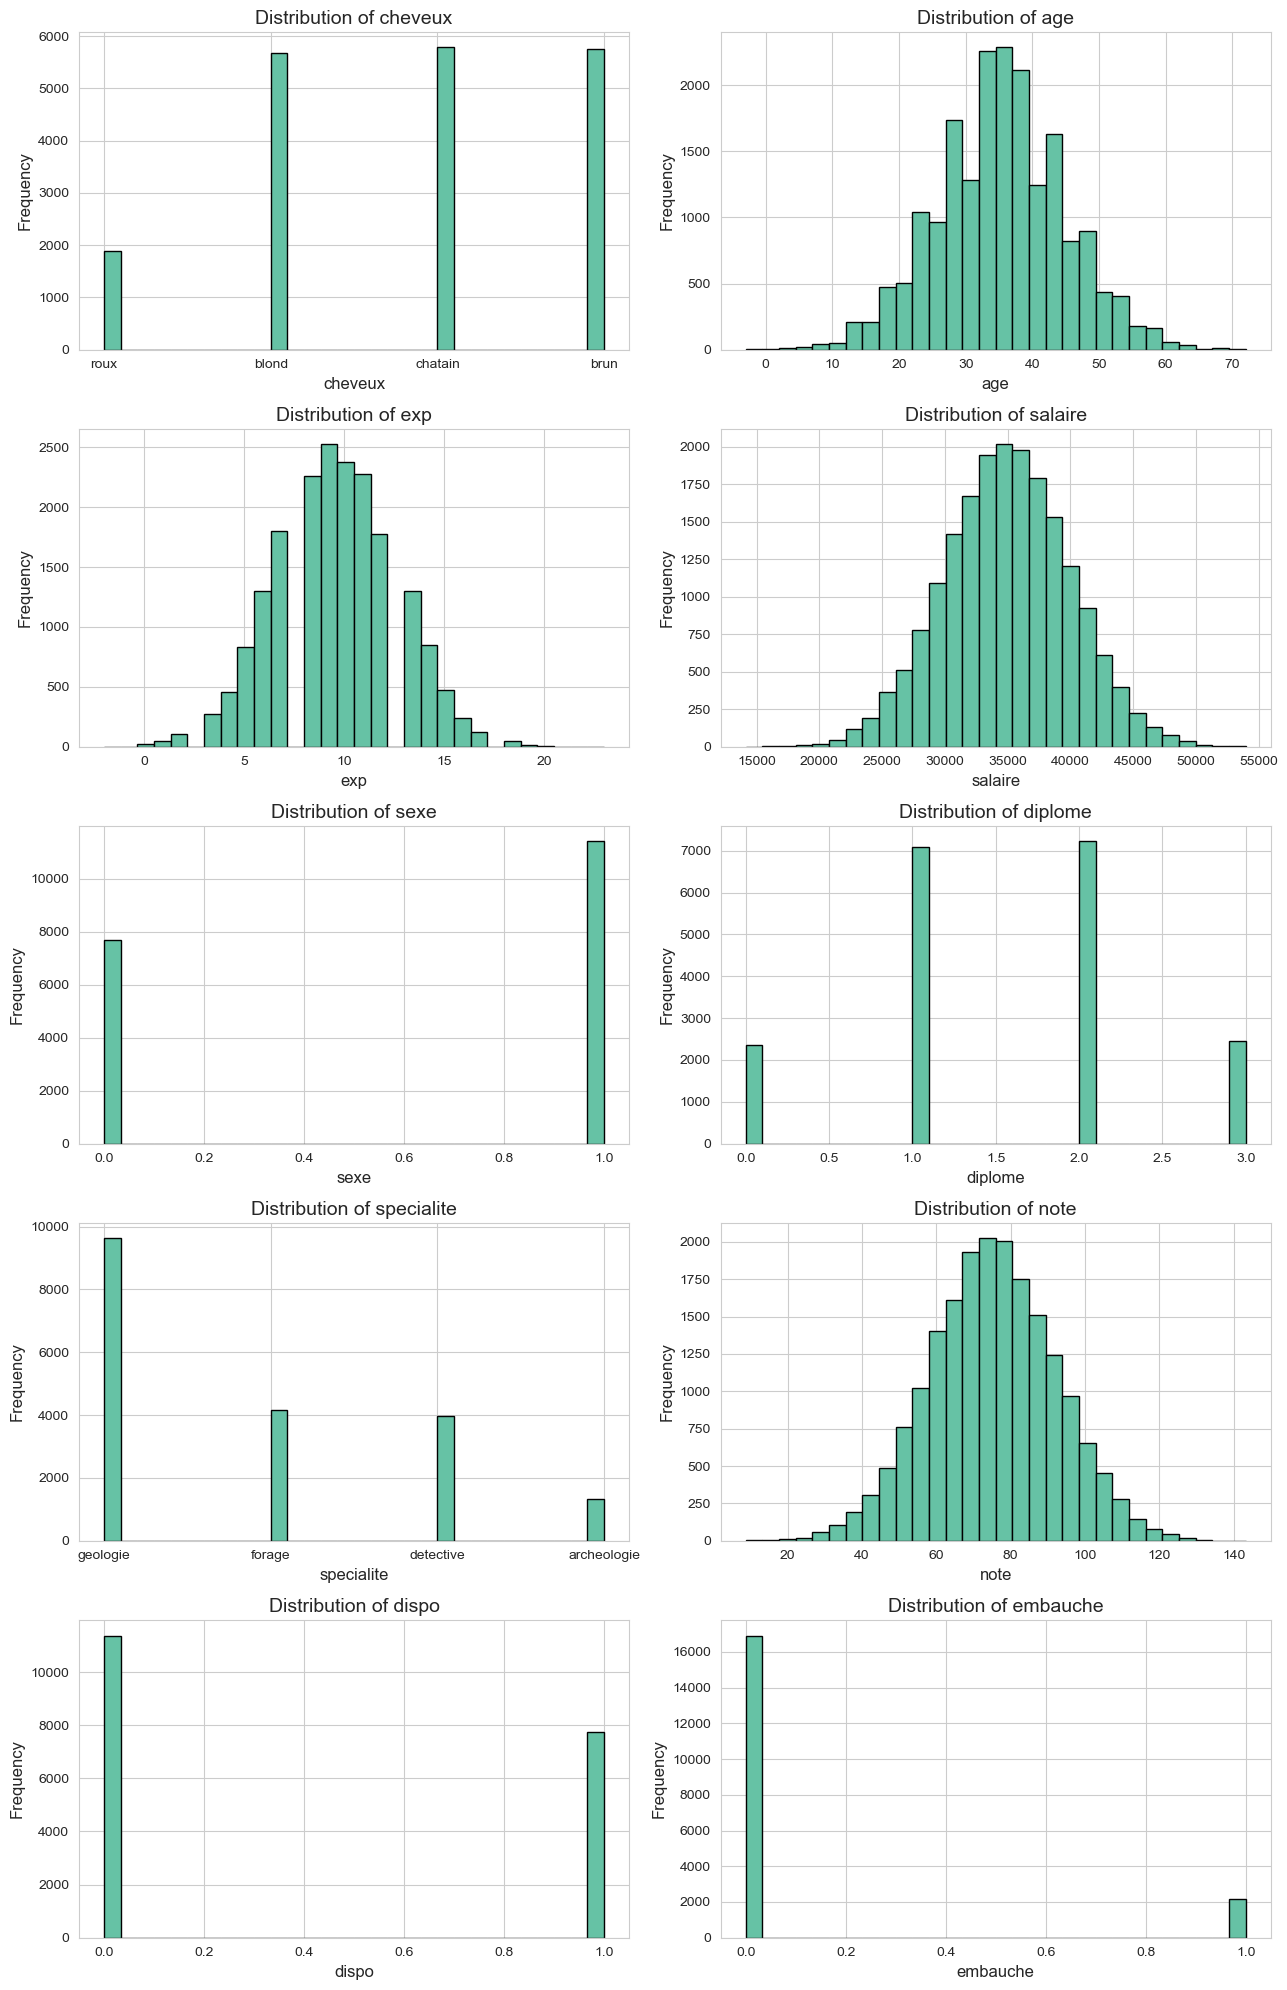

In [57]:
sns.set_style('whitegrid')

num_cols = len(df.columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(13, 20))  # Adjust nrows and ncols

axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, column in enumerate(df.columns):
    df[column].hist(ax=axes[i], bins=30, color=sns.color_palette('Set2')[0], edgecolor='black')
    axes[i].set_title(f"Distribution of {column}", fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

# If the number of columns is odd, you can hide the last subplot if not used
if num_cols % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

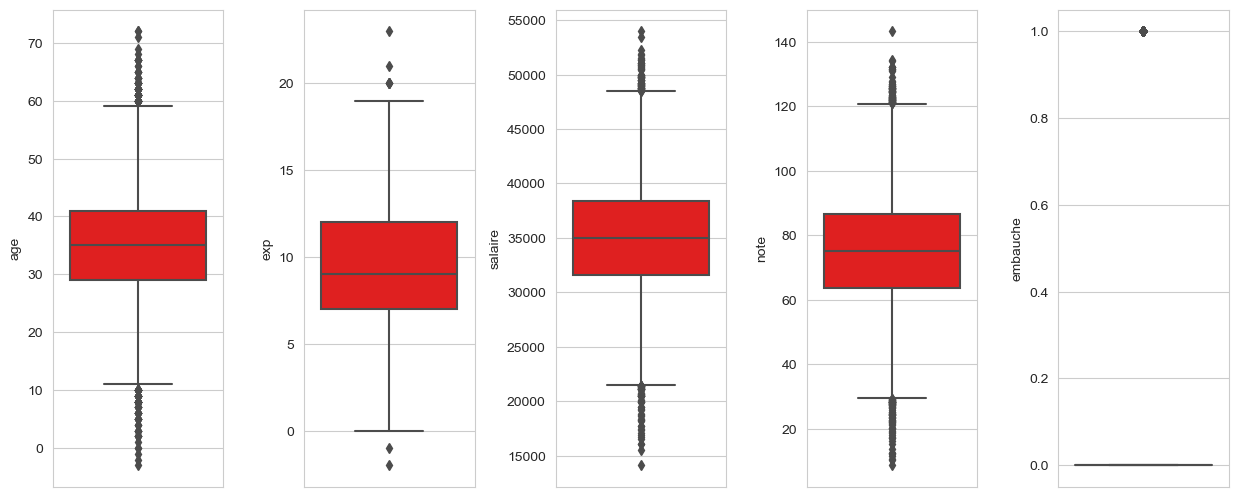

In [17]:
plt.figure(figsize=(15,10))

for index,col in enumerate(df.select_dtypes(include=['int64','float64']).columns,1):
    plt.subplot(2, len(df.columns) // 2 + 1, index)

    sns.boxplot(y=col, data=df, color = 'red')
    plt.tight_layout()

plt.show()

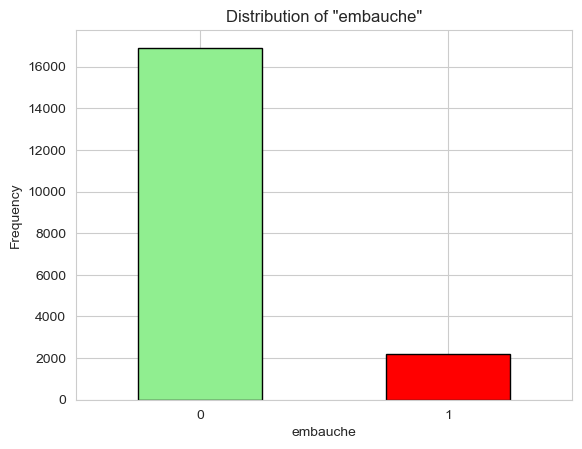

In [18]:
embauche_distribution = df['embauche'].value_counts()

# plotting distribution of Risk Flag 
embauche_distribution.plot(kind='bar', color=['lightgreen', 'red'], edgecolor="k")
plt.xlabel('embauche')
plt.ylabel('Frequency')
plt.title('Distribution of "embauche"')
plt.xticks(rotation=0)
plt.show()

As we can see, the target feature "embauche" exhibits significant imbalance, favoring class 0 (not hired). I dealt with this class imbalance in the modeling section. The other features appear to be well balanced and distributed, despite the presence of some outliers.

### 2.2 *Bivariate Data Analysis*

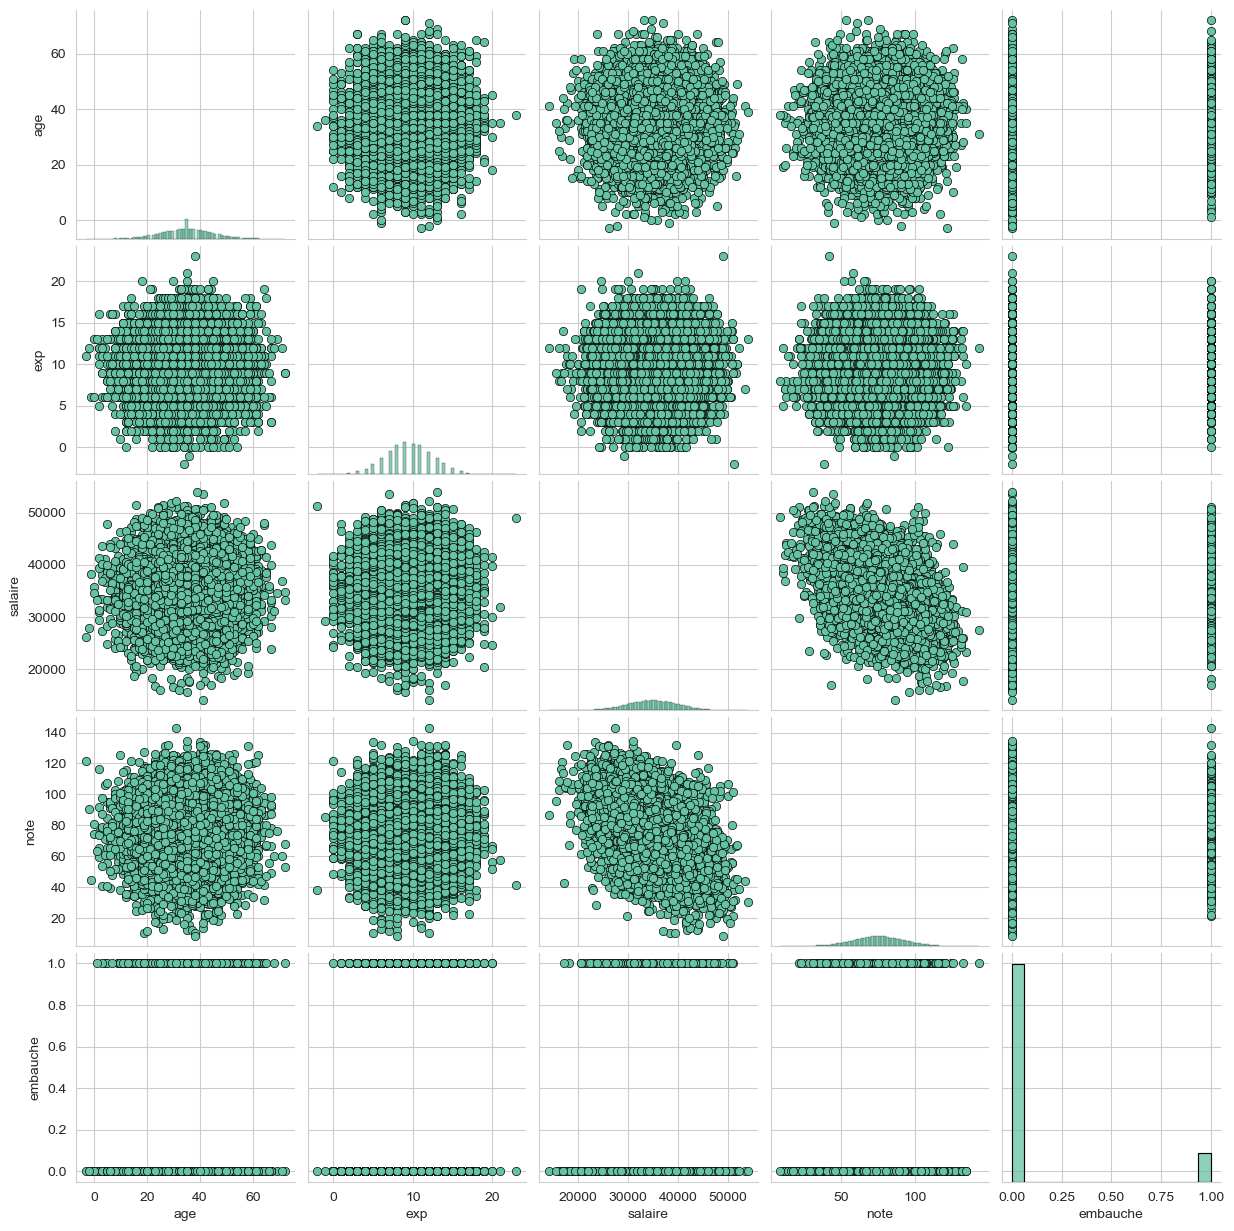

In [19]:
sns.pairplot(df, kind="scatter", 
             diag_kws={"color": sns.color_palette('Set2')[0], "edgecolor": "black"}, 
             plot_kws={"color": sns.color_palette('Set2')[0], "edgecolor": "black"})

plt.show()

In [20]:
corr_matrix = df.select_dtypes(['int','float']).corr()
corr_matrix

,age,exp,salaire,note,embauche
age,1.000000,-0.002343,0.000033,-0.003818,-0.013319
exp,-0.002343,1.000000,0.010216,-0.011031,0.007371
salaire,0.000033,0.010216,1.000000,-0.447945,0.003479
note,-0.003818,-0.011031,-0.447945,1.000000,0.003307
embauche,-0.013319,0.007371,0.003479,0.003307,1.000000


<Axes: >

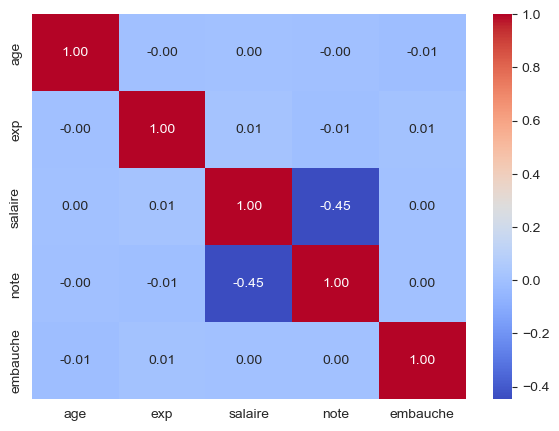

In [21]:
plt.figure(figsize=(7,5))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")

In [22]:
quantitative_columns = df.select_dtypes(['int','float']).columns
# test the significance of the correlation 
for col1, col2 in combinations(quantitative_columns, 2):
    r, p = pearsonr(df[col1], df[col2])
    print(f"Pearson correlation between {col1} and {col2}:")
    print(f"r = {r:.4f}, p-value = {p:.4f}")
    print("_"*49 + "\n")

Pearson correlation between age and exp:
r = -0.0023, p-value = 0.7461
_________________________________________________

Pearson correlation between age and salaire:
r = 0.0000, p-value = 0.9964
_________________________________________________

Pearson correlation between age and note:
r = -0.0038, p-value = 0.5977
_________________________________________________

Pearson correlation between age and embauche:
r = -0.0133, p-value = 0.0656
_________________________________________________

Pearson correlation between exp and salaire:
r = 0.0102, p-value = 0.1579
_________________________________________________

Pearson correlation between exp and note:
r = -0.0110, p-value = 0.1273
_________________________________________________

Pearson correlation between exp and embauche:
r = 0.0074, p-value = 0.3083
_________________________________________________

Pearson correlation between salaire and note:
r = -0.4479, p-value = 0.0000
_________________________________________________

Pe

The most relevant result from the r and p-value analysis was the confirmation of the statistically significant negative correlation between salary and grades, strangely enough. All other correlations were not statistically significant, meaning there was no evidence of a linear relationship between those pairs of variables in my data set.

# 3. **Preprocessing and Modeling**

In this section, I employed a pipeline approach, integrating LogisticRegression, RandomForest, SVC, and eXtremeGradientBoosting models with a preprocessor. Furthermore, I fine-tuned these models using GridSearchCV for hyperparameter tuning, with the excpetion of SVC as it’s computationally too expensive.
<br>I identified the variables specialite and cheveux as candidates for one-hot encoding, while I manually label encoded other variables, such as sexe, diplome and dispo. This encoding choice was based on considerations of either evident cardinality (diplome) or just two unique values per variable (the other two). I opted not to use LabelEncoder() because, in general, it is more suitable for encoding the target variable, not the categorical predictor variables, as it could inadvertently introduce ordinal relationships that don’t exist in the data.

In [23]:
categorical_ohe = ["specialite", "cheveux"] # for preprocessor

In [24]:
# manual label encoding (cardinality or just two variables)
df["sexe"] = df["sexe"].map({"M": 1, "F": 0}) 
df["diplome"] = df["diplome"].map({"bac": 0, "licence": 1, "master": 2, "doctorat": 3})
df["dispo"] = df["dispo"].map({"oui": 1, "non": 0}) 

In [25]:
# Separate the target variable 
X = df.drop(columns=["embauche"])
y = df["embauche"]

In [26]:
# Split your data into train (70%), validation (10%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [27]:
# checking the size of each set
train_size = len(X_train)
validation_size = len(X_val)
test_size = len(X_test)

train_size, validation_size, test_size

(13376, 1911, 3822)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_ohe),  # One-hot encoding for categorical columns
        ],
    remainder='passthrough'  # Pass through other columns
)

In [66]:
# creating pipelines with SMOTE
pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor),  
    ('scaler', StandardScaler()),  
    ('smote', SMOTE(random_state=42)), 
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

pipeline_svc = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42, probability=True))
])

In [68]:
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga'],  
    'classifier__max_iter': [200, 300, 1000, 2000] 
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['specialite',
                                                                          'cheveux'])])),
                                       ('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'classifier__max_iter': [200, 300, 1000, 2000],
                         'classifier__solver': ['lbfgs', 'saga']},
             scoring='roc_auc', verbose=2)

[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.3s
[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.6s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=lib

[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=newton-cg; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.6s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__s

[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=

[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.3s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.5s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=100, classifier__solver=n

[CV] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.3s
[CV] END classifier__C=0.001, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=newton-cg; total time=   0.2s
[CV] END classifier__C=0.001, classifier__max_iter=300, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.01, classifier__max_iter=200, classifier__solver=newton-cg; total time=   0.5s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=lbfgs; total time=   0.2s
[CV] END classifier__C=0.01, classifier__max_iter=300, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__max_iter=100, classifier__solver=newton-cg; total time=   0.4s
[CV] END classifier__C=0.1, classifier__max_iter=200, classifier_

In [69]:
best_lr = grid_search_lr.best_params_
print("Best Parameters:", best_lr)
print("Best Score:", grid_search_lr.best_score_)

Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 200, 'classifier__solver': 'lbfgs'}
Best Score: 0.5669094821722391


In [30]:
# Define the parameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['specialite',
                                                                          'cheveux'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [31]:
best_rf = grid_search_rf.best_params_
print("Best Parameters:", best_rf)
print("Best Score:", grid_search_rf.best_score_)

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best Score: 0.8810104475457633


In [32]:
param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 6, 9],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__subsample': [0.5, 0.7, 1.0],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__colsample_bytree': [0.3, 0.7, 1.0]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['specialite',
                                                                          'cheveux'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.3, 0.7, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__min_child_weight': [1, 2, 3],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.5, 0.7, 1.0]},
             scoring='roc_auc')

In [33]:
best_xgb = grid_search_xgb.best_params_
print("Best Parameters:", best_xgb)
print("Best Score:", grid_search_xgb.best_score_)

Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 9, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.5}
Best Score: 0.887406481501888


In [74]:
pipeline_svc.fit(X_train, y_train) # I didn't use GridSearchCV on SVC since it's computationally too inefficient

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['specialite', 'cheveux'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

# 4. **Evaluation**

In [75]:
# predict probabilities for the positive class (1) for each model on the validation set
probs_lr = grid_search_lr.predict_proba(X_val)[:, 1]  # LogisticRegression
probs_rf = grid_search_rf.predict_proba(X_val)[:, 1]  # RandomForest
probs_xgb = grid_search_xgb.predict_proba(X_val)[:, 1]  # XGBoost
probs_svc = pipeline_svc.predict_proba(X_val)[:, 1]  # SVC

# ROC AUC scores
roc_auc_lr = roc_auc_score(y_val, probs_lr)
roc_auc_rf = roc_auc_score(y_val, probs_rf)
roc_auc_xgb = roc_auc_score(y_val, probs_xgb)
roc_auc_svc = roc_auc_score(y_val, probs_svc)

print(f"Logistic Regression ROC AUC: {roc_auc_lr:.4f}")
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")
print(f"SVC ROC AUC: {roc_auc_svc:.4f}")

best_model = 'Logistic Regression' if (roc_auc_lr > roc_auc_rf and roc_auc_lr > roc_auc_xgb and roc_auc_lr > roc_auc_svc) \
             else 'Random Forest' if (roc_auc_rf > roc_auc_xgb and roc_auc_rf > roc_auc_svc) \
             else 'XGBoost' if roc_auc_xgb > roc_auc_svc \
             else 'SVC'

print(f"The best model based on ROC AUC on the validation set is: {best_model}")

Logistic Regression ROC AUC: 0.5639
Random Forest ROC AUC: 0.8606
XGBoost ROC AUC: 0.8607
SVC ROC AUC: 0.4799
The best model based on ROC AUC on the validation set is: XGBoost


In [76]:
# Predict probabilities for the test set
if best_model == 'Logistic Regression':
    test_probs = grid_search_lr.predict_proba(X_test)[:, 1]
elif best_model == 'Random Forest':
    test_probs = grid_search_rf.predict_proba(X_test)[:, 1]
elif best_model == 'SVC':
    test_probs = pipeline_svc.predict_proba(X_test)[:, 1]
else:  # XGBoost
    test_probs = grid_search_xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC on the test set
roc_auc_test = roc_auc_score(y_test, test_probs)
print(f"{best_model} ROC AUC on Test Set: {roc_auc_test:.4f}")

XGBoost ROC AUC on Test Set: 0.8998


In [85]:
# Sum of ROC AUC scores
total_roc_auc = roc_auc_lr + roc_auc_rf + roc_auc_xgb + roc_auc_svc

# Calculate weights
weight_lr = roc_auc_lr / total_roc_auc
weight_rf = roc_auc_rf / total_roc_auc
weight_xgb = roc_auc_xgb / total_roc_auc
weight_svc = roc_auc_svc / total_roc_auc

# Predict probabilities for the test set using all models
test_probs_lr = grid_search_lr.predict_proba(X_test)[:, 1]
test_probs_rf = grid_search_rf.predict_proba(X_test)[:, 1]
test_probs_xgb = grid_search_xgb.predict_proba(X_test)[:, 1]
test_probs_svc = pipeline_svc.predict_proba(X_test)[:, 1]

# Weighted average of probabilities
test_probs_ensemble = (test_probs_lr * weight_lr + 
                       test_probs_rf * weight_rf + 
                       test_probs_xgb * weight_xgb + 
                       test_probs_svc * weight_svc)

# Calculate ROC AUC on the test set for the ensemble
roc_auc_ensemble = roc_auc_score(y_test, test_probs_ensemble)
print(f"Ensemble ROC AUC on Test Set: {roc_auc_ensemble:.4f}")

Ensemble ROC AUC on Test Set: 0.8974


In [86]:
# ROC curve and ROC AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_probs_lr) # LR
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_rf, tpr_rf, _ = roc_curve(y_test, test_probs_rf) # RF
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, test_probs_xgb) #XGB
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_svc, tpr_svc, _ = roc_curve(y_test, test_probs_svc) #SVC
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, test_probs_ensemble) # ENSEMBLE
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

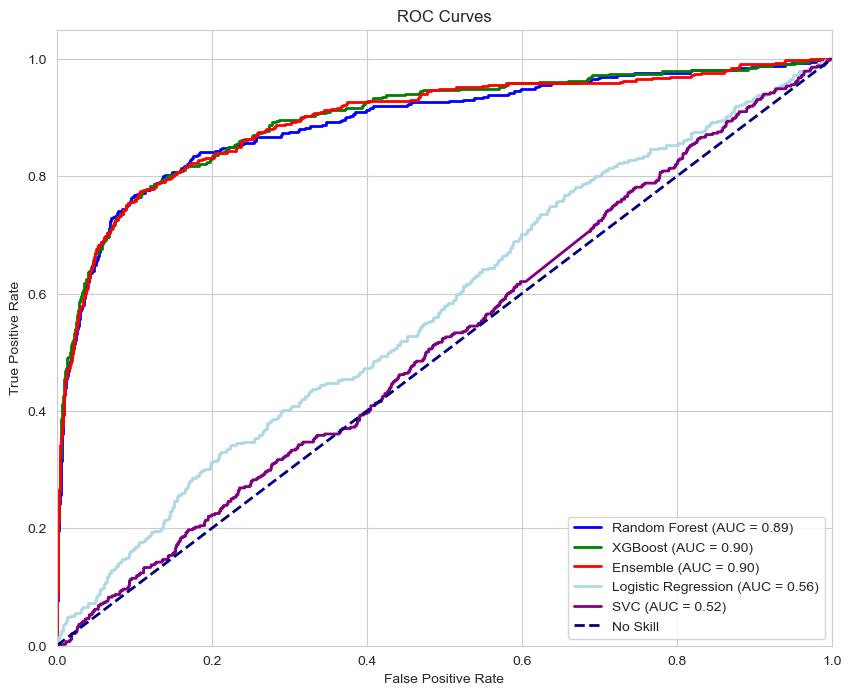

In [88]:
plt.figure(figsize=(10, 8))

# plot ROC Curve
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf) # RF
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb) # XGB
plt.plot(fpr_ensemble, tpr_ensemble, color='red', lw=2, label='Ensemble (AUC = %0.2f)' % roc_auc_ensemble) # ENS
plt.plot(fpr_lr, tpr_lr, color='lightblue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr) # LR
plt.plot(fpr_svc, tpr_svc, color='purple', lw=2, label='SVC (AUC = %0.2f)' % roc_auc_svc) # SVC

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill') # Plot Base Rate ROC

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [84]:
# predict on the training and test sets
train_preds_lr = grid_search_lr.predict(X_train)
test_preds_lr = grid_search_lr.predict(X_test)

# classification reports
report_train_lr = classification_report(y_train, train_preds_lr)
report_test_lr = classification_report(y_test, test_preds_lr)

print("CLASSIFICATION REPORT: Logistic Regression")
print("_"*54 + "\n")
print("Training Set:\n", report_train_lr)
print("_"*54 + "\n")
print("Test Set:\n", report_test_lr)

CLASSIFICATION REPORT: Logistic Regression
______________________________________________________

Training Set:
               precision    recall  f1-score   support

           0       0.90      0.58      0.70     11844
           1       0.13      0.51      0.21      1532

    accuracy                           0.57     13376
   macro avg       0.52      0.54      0.46     13376
weighted avg       0.81      0.57      0.65     13376

______________________________________________________

Test Set:
               precision    recall  f1-score   support

           0       0.90      0.58      0.71      3387
           1       0.13      0.49      0.21       435

    accuracy                           0.57      3822
   macro avg       0.52      0.54      0.46      3822
weighted avg       0.81      0.57      0.65      3822



In [48]:
# predict on the training and test sets
train_preds_rf = grid_search_rf.predict(X_train)
test_preds_rf = grid_search_rf.predict(X_test)

# classification reports
report_train_rf = classification_report(y_train, train_preds_rf)
report_test_rf = classification_report(y_test, test_preds_rf)

print("CLASSIFICATION REPORT: Random Forest")
print("_"*54 + "\n")
print("Training Set:\n", report_train_rf)
print("_"*54 + "\n")
print("Test Set:\n", report_test_rf)

CLASSIFICATION REPORT: Random Forest
______________________________________________________

Training Set:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     11844
           1       0.90      0.58      0.71      1532

    accuracy                           0.94     13376
   macro avg       0.92      0.79      0.84     13376
weighted avg       0.94      0.94      0.94     13376

______________________________________________________

Test Set:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      3387
           1       0.75      0.51      0.60       435

    accuracy                           0.92      3822
   macro avg       0.84      0.74      0.78      3822
weighted avg       0.92      0.92      0.92      3822



In [49]:
# predict on the training and test sets
train_preds_xgb = grid_search_xgb.predict(X_train)
test_preds_xgb = grid_search_xgb.predict(X_test)

# classification reports
report_train_xgb = classification_report(y_train, train_preds_xgb)
report_test_xgb = classification_report(y_test, test_preds_xgb)

print("CLASSIFICATION REPORT: XGB")
print("_"*54 + "\n")
print("Training Set:\n", report_train_xgb)
print("_"*54 + "\n")
print("Test Set:\n", report_test_xgb)

CLASSIFICATION REPORT: XGB
______________________________________________________

Training Set:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     11844
           1       0.81      0.55      0.65      1532

    accuracy                           0.93     13376
   macro avg       0.87      0.76      0.81     13376
weighted avg       0.93      0.93      0.93     13376

______________________________________________________

Test Set:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      3387
           1       0.74      0.54      0.62       435

    accuracy                           0.93      3822
   macro avg       0.84      0.76      0.79      3822
weighted avg       0.92      0.93      0.92      3822



In [50]:
# predict on the training and test sets
train_preds_svc = pipeline_svc.predict(X_train)
test_preds_svc = pipeline_svc.predict(X_test)

# classification reports
report_train_svc = classification_report(y_train, train_preds_svc)
report_test_svc = classification_report(y_test, test_preds_svc)

print("CLASSIFICATION REPORT: SVC")
print("_"*54 + "\n")
print("Training Set:\n", report_train_svc)
print("_"*54 + "\n")
print("Test Set:\n", report_test_svc)

CLASSIFICATION REPORT: SVC
______________________________________________________

Training Set:
               precision    recall  f1-score   support

           0       0.92      0.12      0.22     11844
           1       0.12      0.92      0.21      1532

    accuracy                           0.22     13376
   macro avg       0.52      0.52      0.22     13376
weighted avg       0.83      0.22      0.22     13376

______________________________________________________

Test Set:
               precision    recall  f1-score   support

           0       0.91      0.12      0.22      3387
           1       0.12      0.90      0.21       435

    accuracy                           0.21      3822
   macro avg       0.51      0.51      0.21      3822
weighted avg       0.82      0.21      0.22      3822



I would recommend several steps that could potentially improve my models' performance. 
<br>First, it would be valuable to experiment with additional feature engineering, including interaction terms and polynomial features, which might capture more complex relationships within the data. 
<br>Moreover, exploring more advanced ensemble techniques like stacking or boosting may yield better predictive power by leveraging the diverse strengths of different models.
<br>Lastly, it's crucial to continue refining the data preprocessing and cleaning steps. This could involve gathering more data to reduce the potential bias and variance in the models or applying more sophisticated imputation techniques for missing values.

*<center><font color=blue>Martino Fusai</font></center>*